# Landslide Detection Challenge - Starter Notebook

Welcome to the Landslide Detection Challenge! This notebook will guide you through:
1. Loading and exploring the multi-band dataset provided in `.npy` format.
2. Visualizing the multi-band satellite data and understanding label distribution.
3. Building and evaluating a baseline model to classify landslide and non-landslide images.

Let’s get started with loading and understanding the data!


## Block 1: Import Libraries

In [2]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)

[]


### Explanation
We import the required libraries:
- **os**: for file and directory handling.
- **numpy**: for numerical operations, particularly for loading `.npy` files.
- **pandas**: for data handling with CSV files.
- **matplotlib.pyplot**: for visualizing data, such as label distributions.
- **sklearn.model_selection.train_test_split**: for splitting data into training and validation sets.
- **tensorflow.keras**: for building and training a neural network model.


## Block 2: Define Paths and Load CSV Files

In [4]:
import sys
from pathlib import Path

# Add the src directory to the Python path
sys.path.append(str(Path().resolve().parent / "src"))
from config import TRAIN_CSV_PATH, TEST_CSV_PATH, TRAIN_IMAGE_DIR, TEST_IMAGE_DIR, SUBMISSIONS_DIR

train_df = pd.read_csv(str(TRAIN_CSV_PATH))
test_df = pd.read_csv(str(TEST_CSV_PATH))


print("Train.csv:")
print(train_df.head())

Train.csv:
          ID  label
0  ID_HUD1ST      1
1  ID_KGE2HY      1
2  ID_VHV9BL      1
3  ID_ZT0VEJ      0
4  ID_5NFXVY      0


In [5]:
train_df.label.value_counts()

label
0    5892
1    1255
Name: count, dtype: int64

In [5]:
np.mean(train_df.label)

0.1755981530712187

### Explanation
- **Define Paths**: Specify paths to `Train.csv`, `Test.csv`, and folders containing `.npy` files for training and testing images.
- **Load Train.csv**: We read the `Train.csv` file, which contains `ID` and `label` columns. The `label` is binary, indicating whether the image contains a landslide (1) or not (0).


## Block 3: Visualize Label Distribution

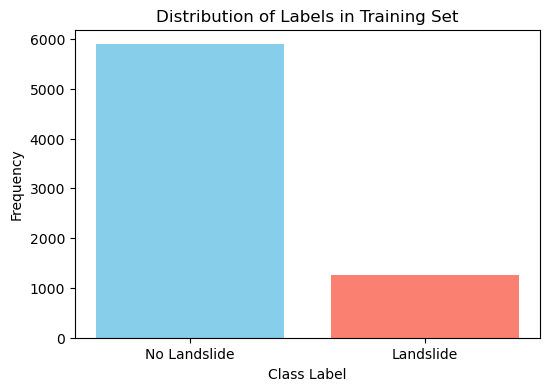

In [6]:
# Check distribution of labels
label_counts = train_df['label'].value_counts()
labels = ['No Landslide', 'Landslide']  # Map the labels 0 and 1 to descriptive names

plt.figure(figsize=(6, 4))
plt.bar(labels, label_counts.values, color=['skyblue', 'salmon'])
plt.xlabel("Class Label")
plt.ylabel("Frequency")
plt.title("Distribution of Labels in Training Set")
plt.show()

### Explanation
This block visualizes the distribution of labels (landslide vs. non-landslide) in the training data.
- `value_counts()` shows the count of each class, and we use a bar chart to display these counts, which helps us understand if the dataset is balanced.


## Block 4: Load, Normalize, and Display Sample Multi-band Images

NameError: name 'load_npy_image' is not defined

In [8]:
plt.imshow(img[:,:,-1])


NameError: name 'img' is not defined

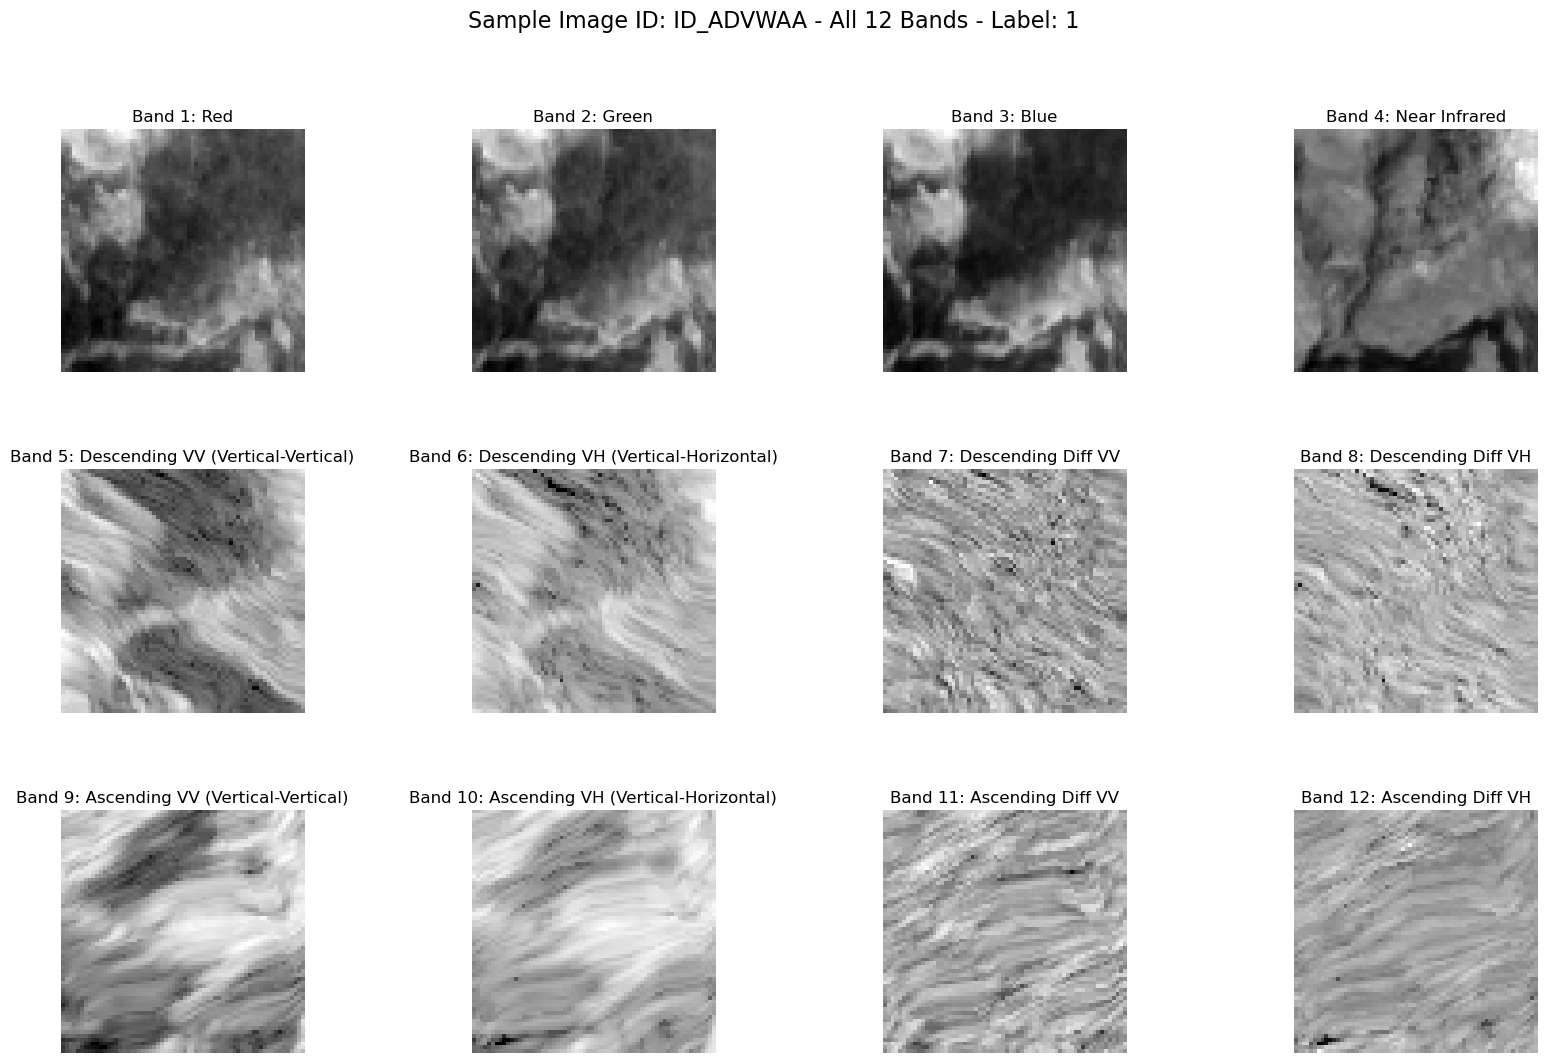

In [120]:
# Function to load and normalize .npy images
def load_and_normalize_npy_image(image_id, folder_path):
    """Loads a .npy file, normalizes each band, and returns the normalized image."""
    image_path = os.path.join(folder_path, f"{image_id}.npy")
    img = np.load(image_path)

    # Normalize each band to the 0-1 range
    img_normalized = (img - img.min(axis=(0, 1))) / (img.max(axis=(0, 1)) - img.min(axis=(0, 1)) + 1e-5)
    return img_normalized

# Function to load and normalize .npy images
def load_npy_image(image_id, folder_path):
    """Loads a .npy file, and returns the image."""
    image_path = os.path.join(folder_path, f"{image_id}.npy")
    img = np.load(image_path)
    return img


# Band descriptions
band_descriptions = [
    "Red", "Green", "Blue", "Near Infrared",
    "Descending VV (Vertical-Vertical)", "Descending VH (Vertical-Horizontal)",
    "Descending Diff VV", "Descending Diff VH",
    "Ascending VV (Vertical-Vertical)", "Ascending VH (Vertical-Horizontal)",
    "Ascending Diff VV", "Ascending Diff VH"
]

# Displaying a few example images with all 12 bands
example_ids = train_df['ID'].sample(1).values  # Randomly select 2 image IDs for illustration

for image_id in example_ids:
    img_normalized = load_and_normalize_npy_image(image_id, TRAIN_IMAGE_DIR)

    label = train_df.label[train_df.ID == image_id].values[0]

    # Plot all 12 bands in a 3x4 grid
    fig, axes = plt.subplots(3, 4, figsize=(20, 12))  # 3 rows, 4 columns for 12 plots
    fig.suptitle(f"Sample Image ID: {image_id} - All 12 Bands - Label: {label}", fontsize=16)

    # Display each of the 12 bands with descriptions
    for band in range(12):
        row = band // 4  # Calculate row index (0, 1, or 2)
        col = band % 4   # Calculate column index (0 to 3)
        axes[row, col].imshow(img_normalized[:, :, band], cmap='gray')
        axes[row, col].set_title(f"Band {band + 1}: {band_descriptions[band]}")
        axes[row, col].axis('off')

    plt.subplots_adjust(wspace=0.3, hspace=0.4)  # Adjust spacing between plots
    plt.show()

In [121]:
img = load_npy_image(image_id, TRAIN_IMAGE_DIR)
img.shape

(64, 64, 12)

In [60]:
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance

def lee_filter(img, size):
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)
    return img_output

C:\Users\phili\AppData\Local\Temp\ipykernel_9252\3305957917.py:1: DeprecationWarning: Please import `uniform_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import uniform_filter
C:\Users\phili\AppData\Local\Temp\ipykernel_9252\3305957917.py:2: DeprecationWarning: Please import `variance` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.measurements import variance


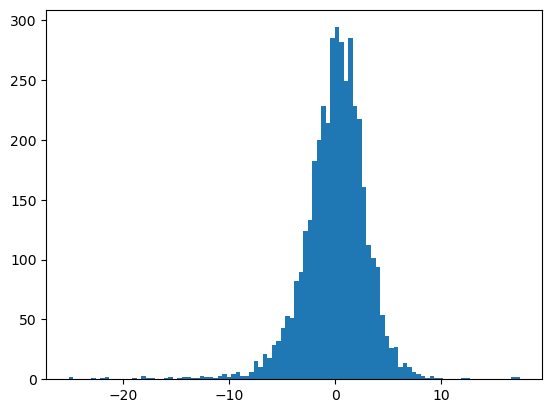

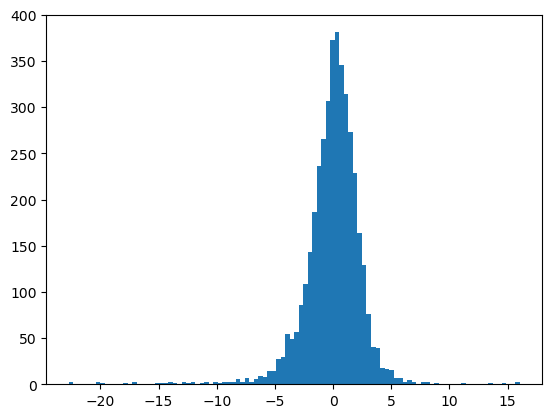

In [75]:
plt.hist(img[:,:,-1].flatten(), bins=100)
plt.show()

denoised_img = lee_filter(img[:,:,-1], 3)
plt.hist(denoised_img.flatten(), bins=100)
plt.show()

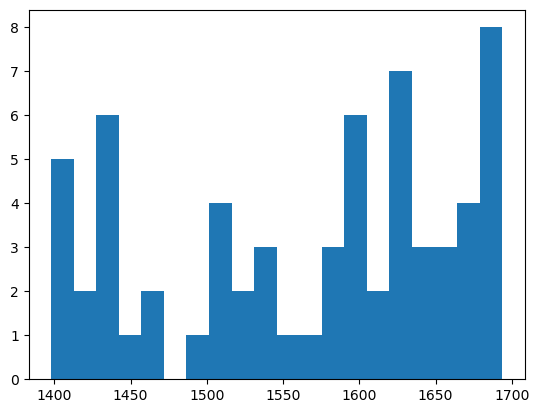

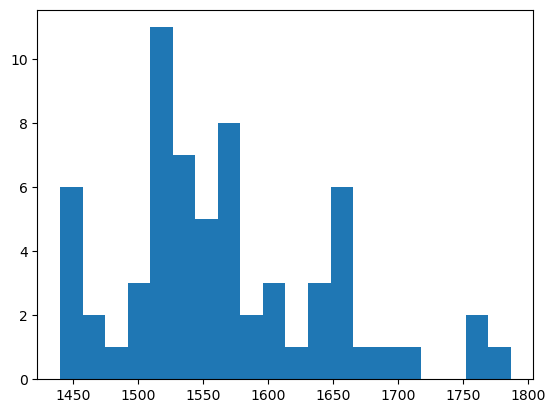

In [76]:
plt.hist(np.mean(img[:,:,0], axis=0), bins=20)
plt.show()

plt.hist(np.mean(img[:,:,0], axis=1), bins=20)
plt.show()

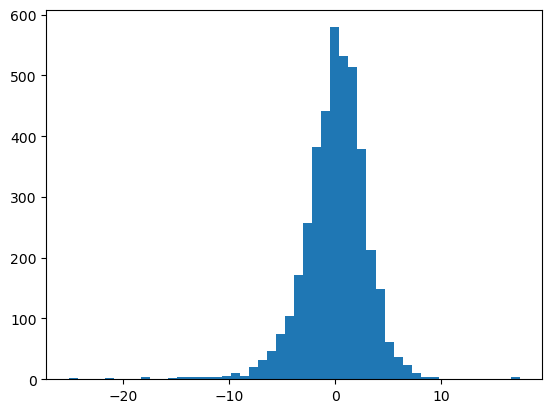

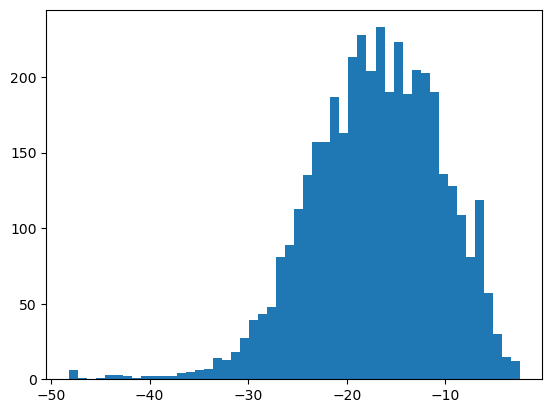

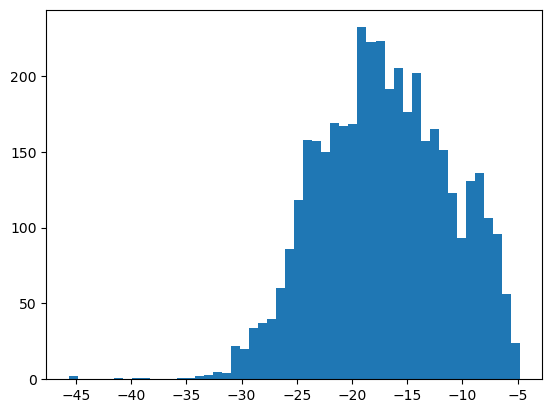

In [77]:
plt.hist(img[:,:,-1].flatten(), bins=50)
plt.show()

plt.hist((img[:,:,-3]).flatten() , bins=50)
plt.show()
plt.hist((img[:,:,-3] - img[:,:,-1]).flatten() , bins=50)
plt.show()

In [78]:
from scipy.stats import ks_2samp
stat, p_value = ks_2samp(np.mean(img[:,:,1], axis=0), np.mean(img[:,:,1], axis=1))
print(stat, p_value)

0.25 0.03624313869735272


In [65]:
pos_pvals = []
neg_pvals = []
for image_id in train_df['ID'].values:
    img_normalized = load_npy_image(image_id, TRAIN_IMAGE_DIR)

    label = train_df.label[train_df.ID == image_id].values[0]
    stat, p_value = ks_2samp(np.mean(img_normalized[:,:,0], axis=0), np.mean(img_normalized[:,:,0], axis=1))
    if label == 1:
        pos_pvals.append(p_value)
    else:
        neg_pvals.append(p_value)


KeyboardInterrupt: 

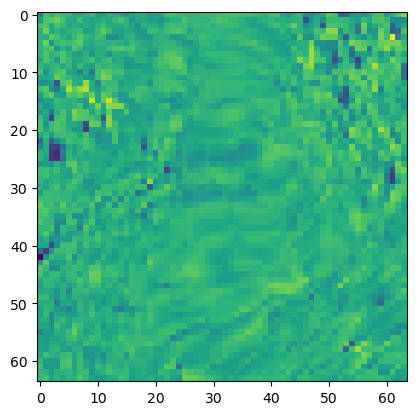

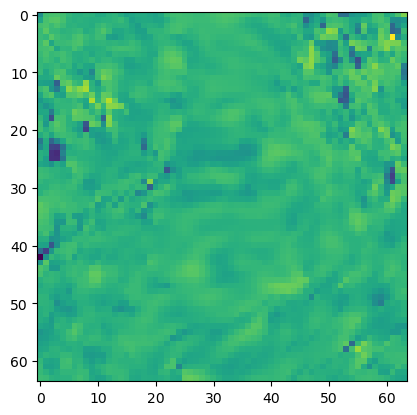

In [89]:

plt.imshow(img[:,:,-1])
plt.show()
denoised_img = lee_filter(img[:,:,-1], 3)
plt.imshow(denoised_img)
plt.show()

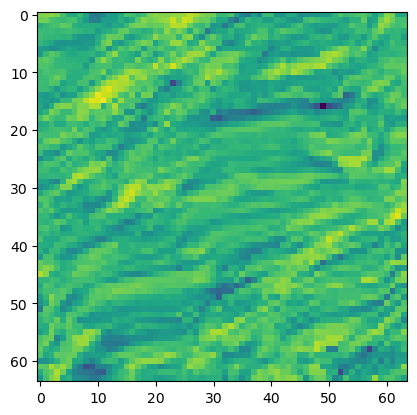

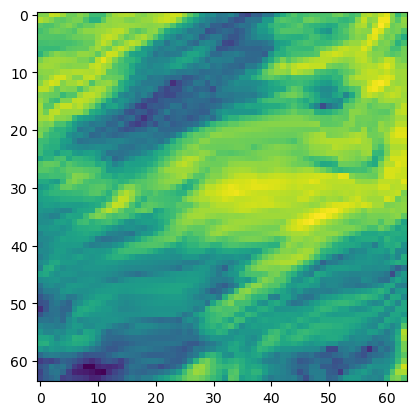

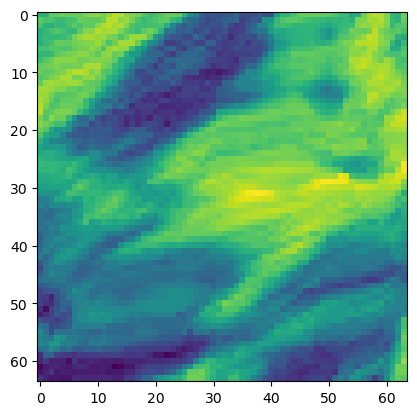

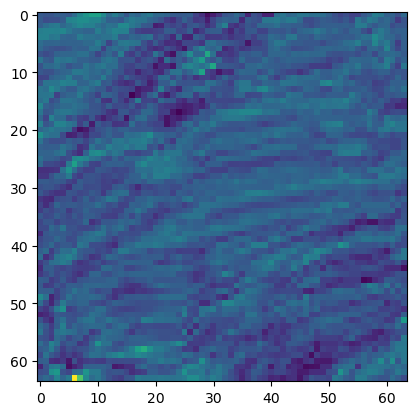

In [125]:
plt.imshow(img[:,:,-2])
plt.show()
plt.imshow(img[:,:,-4])
plt.show()
plt.imshow((img[:,:,-4] - img[:,:,-2]))
plt.show()
vv_vh_ratio = (img[:,:,-4] - img[:,:,-2]) - (img[:,:,-3] - img[:,:,-1])
plt.imshow(vv_vh_ratio)
plt.show()

(array([  3.,   6.,  11.,  20.,  28.,  44.,  66.,  88., 123., 204., 254.,
        287., 367., 432., 403., 407., 372., 277., 248., 185., 118.,  58.,
         36.,  22.,  15.,   8.,   3.,   1.,   5.,   1.,   1.,   1.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([ 0.15048907,  0.56580229,  0.98111552,  1.39642874,  1.81174197,
         2.2270552 ,  2.64236842,  3.05768165,  3.47299487,  3.8883081 ,
         4.30362132,  4.71893455,  5.13424777,  5.549561  ,  5.96487422,
         6.38018745,  6.79550067,  7.2108139 ,  7.62612712,  8.04144035,
         8.45675357,  8.8720668 ,  9.28738002,  9.70269325, 10.11800647,
        10.5333197 , 10.94863292, 11.36394615, 11.77925937, 12.1945726 ,
        12.60988582, 13.02519905, 13.44051227, 13.8558255 , 14.27113872,
        14.68645195, 15.10176517, 15.5170784 , 15.93239162, 16.34770485,
        16.76301807, 17.1783313 , 17.59364452, 18.00895775, 18.42427097,
 

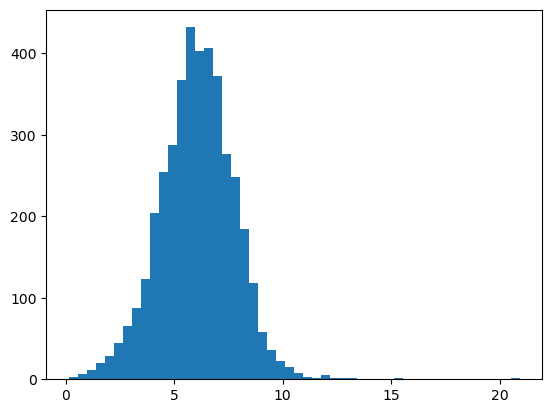

In [126]:
plt.hist(vv_vh_ratio.flatten(), bins=50)

In [41]:
np.max(denoised_img)

4.9844682636484485

### Explanation
This block provides a complete view of the 12 individual bands with the corrected descriptions for ascending and descending radar bands.

1. **Band Descriptions**:
   - **Bands 1-4**: Visible and Near Infrared bands (Red, Green, Blue, NIR).
   - **Bands 5-8**: Descending radar bands:
     - **Band 5**: Descending VV (Vertical-Vertical polarization).
     - **Band 6**: Descending VH (Vertical-Horizontal polarization).
     - **Band 7**: Descending Diff VV.
     - **Band 8**: Descending Diff VH.
   - **Bands 9-12**: Ascending radar bands:
     - **Band 9**: Ascending VV (Vertical-Vertical polarization).
     - **Band 10**: Ascending VH (Vertical-Horizontal polarization).
     - **Band 11**: Ascending Diff VV.
     - **Band 12**: Ascending Diff VH.

2. **Plotting Layout**:
   - A 3x4 grid layout displays each band as a grayscale image.
   - Each subplot includes the band number and description for easy reference.
   - `plt.subplots_adjust` adds spacing between the plots to improve readability.


## Block 5: Prepare Data for Model Training

In [28]:
# BEWARE - THIS TAKES FOREVER TO RUN -- INSTEAD USE A Generator
# Avoid loading all images from *.npy into array first.

# Path to the folder containing .npy images
folder_path = TRAIN_IMAGE_DIR

X = np.array([load_and_normalize_npy_image(image_id, folder_path) for image_id in train_df['ID']])
y = train_df['label'].values

# Perform a stratified split to maintain class distribution
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define data augmentation for training
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Define a simple generator for validation (no augmentation)
val_datagen = ImageDataGenerator()

# Define batch size
batch_size = 32

# Create generators using .flow()
train_ds = train_datagen.flow(
    X_train, y_train, batch_size=batch_size, seed=42, shuffle=True
)

val_ds = val_datagen.flow(
    X_val, y_val, batch_size=batch_size, seed=42, shuffle=True
)

d:\anaconda3\envs\tensor\lib\site-packages\keras\src\legacy\preprocessing\image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (5717, 64, 64, 12) (12 channels).
  warnings.warn(
d:\anaconda3\envs\tensor\lib\site-packages\keras\src\legacy\preprocessing\image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1430, 64, 64, 12) (12 channels).
  warnings.warn(


### Explanation

1. **Load Data**:
   - We define `load_npy_image` to load `.npy` files as raw images.
   - `X` is created by loading each image using `load_npy_image` based on the image IDs in `train_df`.
   - `y` contains the labels from `train_df`.

2. **Stratified Data Split**:
   - We split the data into `X_train`, `X_val`, `y_train`, and `y_val` while preserving class distribution using `stratify=y`.

3. **ImageDataGenerator for Training**:
   - `train_datagen` is configured with data augmentation options to increase the diversity of the training data.

4. **ImageDataGenerator for Validation**:
   - `val_datagen` loads the validation data without augmentation.

5. **Generators**:
   - `train_ds` and `val_ds` are created using `.flow()`, which yields data in batches for efficient training and validation.

In [29]:
X_batch, y_batch = train_ds[0]

In [30]:
X_batch.shape, y_batch.shape


((32, 64, 64, 12), (32,))

In [31]:
y_batch

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [32]:
X_val_batch, y_val_batch = val_ds[0]

In [33]:
X_val_batch.shape, y_val_batch.shape

((32, 64, 64, 12), (32,))

## Block 6: Define and Compile a CNN Model with Focal Loss

In [58]:
# Precision metric
def precision_m(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')  # Cast y_true to float32 to match y_pred type
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

# Recall metric
def recall_m(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')  # Cast y_true to float32 to match y_pred type
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


# F1 Score metric
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))


# Define the 
#  Loss function
def focal_loss(gamma=2.0, alpha=0.25):
    """
    Focal Loss for binary classification.

    Parameters:
        gamma (float): Focusing parameter; typically set to 2.0.
        alpha (float): Balancing factor; typically set to 0.25.

    Returns:
        Binary Focal Loss function.
    """
    def focal_loss_fixed(y_true, y_pred):
        # Clip predictions to prevent log(0)
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())

        # Calculate p_t
        p_t = tf.where(K.equal(y_true, 1), y_pred, 1 - y_pred)

        # Calculate focal loss
        fl = -alpha * K.pow(1 - p_t, gamma) * K.log(p_t)
        return K.mean(fl)

    return focal_loss_fixed

# Define the CNN model
model = Sequential([
    # First convolutional block
    Input(shape=X_batch.shape[1:]),
    Conv2D(32, (3, 3), activation='relu', data_format='channels_last'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Second convolutional block
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Third convolutional block
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Fourth convolutional block for deeper feature extraction
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.5),

    # Flatten and add dense layers
    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),  # Dropout for regularization
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
])

# Compile the model with Focal Loss and additional metrics
model.compile(
    optimizer='adam',
    loss=focal_loss(gamma=1.0, alpha=0.75),
    metrics=['accuracy', precision_m, recall_m, f1_m]  # Additional metrics
)

# Display the model summary
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 62, 62, 32)     │         3,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 29, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │             

 Total params: 533,217 (2.03 MB)

 Trainable params: 531,873 (2.03 MB)

 Non-trainable params: 1,344 (5.25 KB)

### Explanation

This code defines a Convolutional Neural Network (CNN) with custom metrics (Precision, Recall, and F1 Score) and **Focal Loss** for training, making it suitable for imbalanced datasets.

#### Key Components

1. **Custom Metrics**:
   - `precision_m`: Calculates the proportion of true positive predictions out of all positive predictions, which helps evaluate the model’s accuracy in predicting positive (landslide) samples.
   - `recall_m`: Measures the proportion of true positives out of all actual positives, reflecting the model’s ability to detect all positive cases.
   - `f1_m`: Combines Precision and Recall into a single score using the harmonic mean, making it useful for evaluating the model on imbalanced datasets.

2. **Focal Loss Function**:
   - Focal Loss is designed to focus on hard-to-classify examples, making it particularly beneficial for imbalanced datasets.
   - Parameters:
     - `gamma=2.0`: Adjusts the focusing mechanism. Higher values place more focus on misclassified examples.
     - `alpha=0.25`: Balances the contribution of positive and negative samples, ensuring the loss calculation doesn’t get dominated by the majority class.
   - The function `focal_loss_fixed` calculates Focal Loss by:
     - Clipping predictions to avoid `log(0)`.
     - Calculating the probability for each prediction (`p_t`), where correct predictions contribute less to the loss.
     - Applying the focal scaling factor `(1 - p_t)^{\gamma}` to emphasize harder examples in the loss computation.

3. **CNN Model Architecture**:
   - The CNN is designed with four convolutional blocks, each containing:
     - **Conv2D layers**: Extract features with increasing complexity as the model goes deeper.
     - **BatchNormalization layers**: Normalize activations, speeding up convergence and improving stability.
     - **MaxPooling2D layers**: Down-sample feature maps, reducing spatial dimensions and capturing abstract patterns.
     - **Dropout layers**: Applied with increasing rates, reducing overfitting by randomly deactivating nodes during training.
   - Following the convolutional blocks:
     - **Flatten**: Converts 2D feature maps to a 1D vector.
     - **Dense layers**: Two fully connected layers with ReLU activation capture higher-level features, with Dropout for regularization.
     - **Sigmoid Output Layer**: Used for binary classification, outputs the probability of each class (No Landslide or Landslide).

4. **Model Compilation**:
   - `optimizer='adam'`: An adaptive optimizer that adjusts the learning rate automatically during training.
   - `loss=focal_loss(gamma=2.0, alpha=0.25)`: Focal Loss to handle class imbalance.
   - `metrics=['accuracy', precision_m, recall_m, f1_m]`: Additional metrics for a comprehensive evaluation of the model's performance on imbalanced data.

5. **Model Summary**:
   - `model.summary()` displays the model’s architecture, showing layer types, output shapes, and parameter counts. This summary helps verify that the model structure matches expectations before training begins.

## Block 7: Train the Model

In [59]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Create a checkpoint callback that saves the best model based on validation loss
checkpoint = ModelCheckpoint(
    "best_model.keras",            # Filepath to save the model
    monitor='val_loss',         # Monitor the validation loss
    verbose=1,                  # Verbosity mode; 1 prints messages when a new best is found
    save_best_only=True,        # Save only the model with the best performance
    mode='min'                  # 'min' mode because lower validation loss is better
)

# Train the model using the generators with the checkpoint callback
history = model.fit(
    train_ds,       # Train generator
    epochs=50,
    validation_data=val_ds,  # Validation generator
    callbacks=[checkpoint]   # Include the checkpoint callback in training
)


Epoch 1/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.6318 - f1_m: 6.8385 - loss: 0.3191 - precision_m: 5.5906 - recall_m: 11.0199
Epoch 1: val_loss improved from inf to 0.26912, saving model to best_model.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 25s 116ms/step - accuracy: 0.6322 - f1_m: 6.8324 - loss: 0.3187 - precision_m: 5.5902 - recall_m: 11.0008 - val_accuracy: 0.8245 - val_f1_m: 0.0000e+00 - val_loss: 0.2691 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.8179 - f1_m: 2.9817 - loss: 0.1652 - precision_m: 5.0996 - recall_m: 2.3889
Epoch 2: val_loss did not improve from 0.26912
179/179 ━━━━━━━━━━━━━━━━━━━━ 21s 113ms/step - accuracy: 0.8179 - f1_m: 2.9834 - loss: 0.1652 - precision_m: 5.1011 - recall_m: 2.3905 - val_accuracy: 0.8245 - val_f1_m: 0.0000e+00 - val_loss: 0.2846 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/50
178/179 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.82

### Explanation

1. **Model Training**:
   - `model.fit` is updated to use the `train_generator` and `val_generator`.
   - `steps_per_epoch` and `validation_steps` control how many batches are processed per epoch for training and validation.
2. **Efficiency**:
   - Using a generator allows the model to load data in batches, reducing memory usage and making training feasible for large datasets.

## Block 8: Plot Training and Validation Accuracy

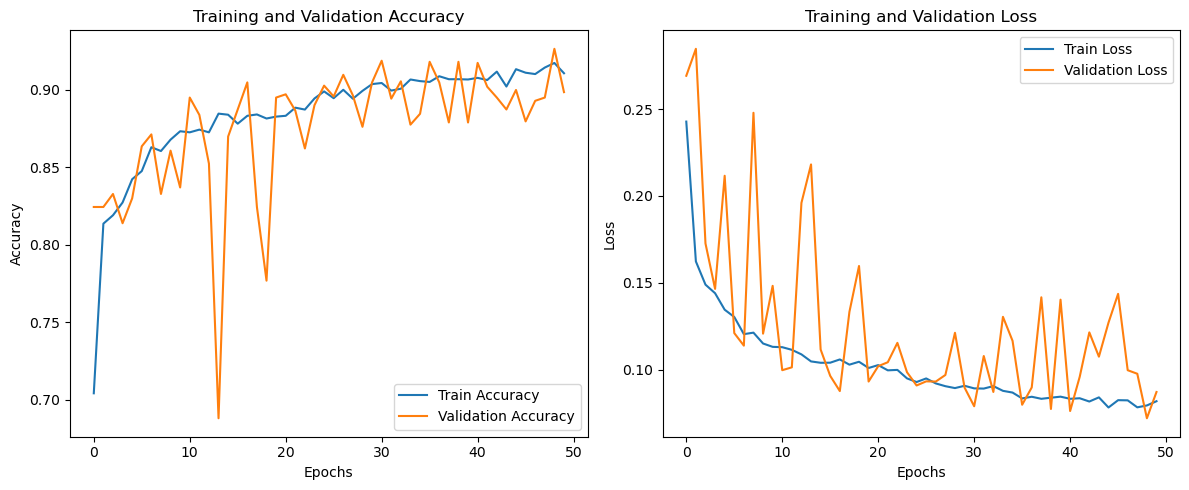

In [60]:
# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()


### Explanation
This plot shows the **training and validation accuracy** as well as the **training and validation loss** over the epochs, allowing us to visually inspect the model’s learning behavior:

- **Steady Improvements in Both Accuracy and Loss**: Consistent increases in accuracy and decreases in loss for both training and validation sets indicate effective learning and good generalization.

- **Divergence Between Training and Validation Metrics**:
  - If **training accuracy is high** but **validation accuracy is much lower** (with validation loss increasing), this suggests **overfitting**. The model may perform well on training data but fails to generalize to new data.
  - If both **training and validation accuracy remain low** and losses are high, this indicates **underfitting**, meaning the model may not be complex enough to capture patterns in the data.

This combined plot of accuracy and loss offers a comprehensive view of model performance, helping us assess both how well the model fits the training data and how well it generalizes to new, unseen data.


## Block 9: Make Predictions on the Test Set and Prepare Submission

In [62]:
# Loading the full test dataset is not probably the best approach

# Load and predict on the test set
test_ids = test_df['ID'].values
X_test = np.array([load_and_normalize_npy_image(image_id, TEST_IMAGE_DIR) for image_id in test_ids])

# Predict probabilities and classify as 0 or 1
y_test_pred = (model.predict(X_test) > 0.5).astype(int) # the output is a probability that goes from 0 to 1.
                                                        # Here we use 0.5 as the threshold

# Count the number of predictions for each class
unique, counts = np.unique(y_test_pred, return_counts=True)
prediction_counts = dict(zip(unique, counts))
print("Prediction counts:", prediction_counts)
print(np.mean(y_test_pred.flatten()))
# Prepare submission file
submission_df = pd.DataFrame({
    'ID': test_ids,
    'label': y_test_pred.flatten()  # Flatten to match submission format
})
submission_df.to_csv(SUBMISSIONS_DIR / 'Submission_starter_notebook.csv', index=False)
print("Sample submission file created as 'Submission_starter_notebook.csv'.")

169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Prediction counts: {0: 5040, 1: 358}
0.06632085957762134
Sample submission file created as 'Submission_starter_notebook.csv'.


0.05854020007410152

### Explanation
1. **Count Predictions**:
   - After making predictions on `X_test`, we use `np.unique` with `return_counts=True` to count the occurrences of `0`s and `1`s in `y_test_pred`.
   - We print the counts, which shows the distribution of predicted labels.

2. **Interpretation**:
   - The counts provide insight into whether the model is predicting a balanced number of `0`s and `1`s or if it's skewed towards one class.
   - Please consider that the test set is imbalanced towards the non-landslide class.
   - This check is particularly useful for binary classification problems where class imbalance could impact the model’s evaluation.

3. **Prepare Submission File**:
   - The `Submission_File.csv` file is created in the same way, ready for submission.